In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Microcontroladores/Project

Mounted at /gdrive
/gdrive/MyDrive/Microcontroladores/Project


In [4]:
#@title Importe de librerías
%tensorflow_version 1.x
import cv2,os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [7]:
#@title Creando el dataset
categories=os.listdir('categorias')
labels=[i for i in range(len(categories))]
label_dict=dict(zip(categories,labels)) # Asignar numero por categoría.
print(label_dict)
print(categories)
print(labels)

img_size=100
Images = []
Labels = [] 

def obtener_dataset(ruta): #Obtener y Etiquetar las imágenes según la ruta
  for labels in os.listdir(ruta): 

    for imgs in os.listdir(ruta+labels): 
      img = cv2.imread(ruta+labels+r'/'+imgs) 
      img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
      img=cv2.resize(img_gray,(img_size,img_size))
      Images.append(img)
      Labels.append(label_dict[labels])

  return Images,Labels #Retorna todas las imágenes del directorio con su respectiva etiqueta

{'without mask': 0, 'with mask': 1}
['without mask', 'with mask']
[0, 1]


In [42]:
#@title Data processing

data, labels = obtener_dataset('categorias/')
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
labels=np.array(labels)
labels=np_utils.to_categorical(labels)
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.15)


print("Total data shape: ",data.shape)
print("Train examples: ",train_data.shape[0])
print("Test examples: ",test_data.shape[0])

Total data shape:  (5504, 100, 100, 1)
Train examples:  4678
Test examples:  826


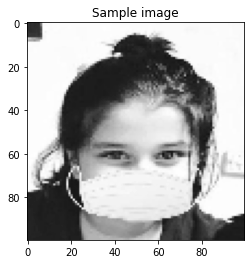

In [53]:
#@title Sample image
rand = np.random.randint(len(train_data))
img_testing = data[rand].reshape(img_size,img_size)
plt.imshow(img_testing,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("Sample image")
plt.show()

In [56]:
#@title CNN architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='glorot_normal', bias_initializer='he_normal', padding='same', input_shape=data.shape[1:]))
model.add(MaxPooling2D((4, 4)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(50, kernel_initializer='glorot_normal', bias_initializer='he_uniform',  activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(
  train_data, train_labels,
  epochs=25,
  validation_split=0.18,
  verbose=1) 



Train on 3835 samples, validate on 843 samples
Epoch 1/25
3835/3835 [==============================] - 8s 2ms/step - loss: 0.5989 - accuracy: 0.6965 - val_loss: 0.3846 - val_accuracy: 0.8612
Epoch 2/25
3835/3835 [==============================] - 1s 274us/step - loss: 0.2515 - accuracy: 0.9009 - val_loss: 0.2092 - val_accuracy: 0.9407
Epoch 3/25
3835/3835 [==============================] - 1s 290us/step - loss: 0.1452 - accuracy: 0.9541 - val_loss: 0.1290 - val_accuracy: 0.9692
Epoch 4/25
3835/3835 [==============================] - 1s 276us/step - loss: 0.1085 - accuracy: 0.9640 - val_loss: 0.1086 - val_accuracy: 0.9751
Epoch 5/25
3835/3835 [==============================] - 1s 280us/step - loss: 0.0844 - accuracy: 0.9729 - val_loss: 0.1661 - val_accuracy: 0.9407
Epoch 6/25
3835/3835 [==============================] - 1s 288us/step - loss: 0.0707 - accuracy: 0.9768 - val_loss: 0.0891 - val_accuracy: 0.9775
Epoch 7/25
3835/3835 [==============================] - 1s 287us/step - loss: 

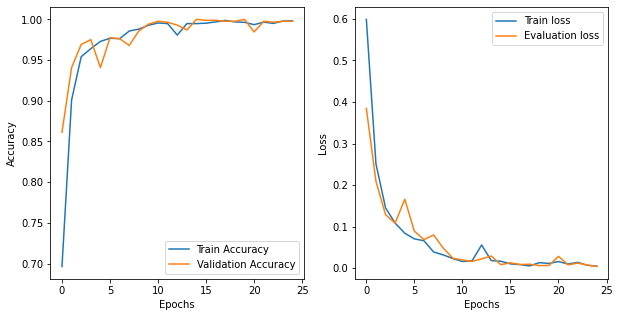

In [57]:
#@title CNN Performance

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='Train loss');
ax.plot(history.history['val_loss'], label='Evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [59]:
#@title Evaluación del modelo

print("Evaluate on test data")
results = model.evaluate(test_data, test_labels)
print("test loss, test acc:", results)

Evaluate on test data
826/826 [==============================] - 0s 204us/step
test loss, test acc: [0.005008348372322902, 0.9975786805152893]


In [61]:
#@title Detección
model.save('mask.h5')